In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:


def generate_samples(df, label, feature_columns, n_samples):
    """
    Generate new samples for a given class by randomly sampling feature values
    within the range of existing samples.
    """
    class_df = df[df[label_column] == label]
    new_samples = []
    
    for _ in range(n_samples):
        new_sample = {}
        for feature in feature_columns:
            min_val = class_df[feature].min()
            max_val = class_df[feature].max()
            new_sample[feature] = np.random.uniform(min_val, max_val)
        new_sample[label_column] = label
        new_samples.append(new_sample)
    
    return pd.DataFrame(new_samples)

def similarity_based_sampling(df, label_column, feature_columns, min_samples=5, 
                              max_samples=None, similarity_threshold=0.8, 
                              sampling_strategy='auto', balance_ratio=0.5):
    """
    Perform similarity-based sampling on the dataset with controlled over-sampling.
    
    :param df: pandas DataFrame containing the dataset
    :param label_column: name of the column containing class labels
    :param feature_columns: list of column names to use as features
    :param min_samples: minimum number of samples to keep for each class
    :param max_samples: maximum number of samples for any class after balancing
    :param similarity_threshold: threshold for cosine similarity
    :param sampling_strategy: sampling strategy for SMOTE
    :param balance_ratio: ratio of minority to majority class samples
    :return: DataFrame with balanced samples
    """
    
    label_counts = Counter(df[label_column])
    max_count = max(label_counts.values())
    
    if max_samples is None:
        max_samples = max_count
    
    selected_samples = []
    generated_samples = pd.DataFrame()
    
    for label, count in label_counts.items():
        label_df = df[df[label_column] == label]
        
        if count < min_samples:
            selected_samples.extend(label_df.index)
            n_generate = min_samples - count
            new_samples = generate_samples(df, label, feature_columns, n_generate)
            generated_samples = pd.concat([generated_samples, new_samples], ignore_index=True)
        elif count <= min_samples:
            selected_samples.extend(label_df.index)
        else:
            scaler = StandardScaler()
            features_scaled = scaler.fit_transform(label_df[feature_columns])
            
            similarity_matrix = cosine_similarity(features_scaled)
            
            selected = set()
            for i in range(similarity_matrix.shape[0]):
                if i not in selected:
                    selected.add(i)
                    similar = np.where(similarity_matrix[i] > similarity_threshold)[0]
                    selected.update(similar[:max(1, len(similar)//2)])
            
            if len(selected) < min_samples:
                remaining = set(range(similarity_matrix.shape[0])) - selected
                selected.update(list(remaining)[:min_samples - len(selected)])
            
            selected_samples.extend(label_df.iloc[list(selected)].index)
    
    selected_df = df.loc[selected_samples]
    combined_df = pd.concat([selected_df, generated_samples], ignore_index=True)
    
    # Calculate target samples for each class
    target_samples = int(max(min_samples, balance_ratio * max_count))
    target_samples = min(target_samples, max_samples)
    
    # Prepare sampling strategy
    class_counts = Counter(combined_df[label_column])
    sampling_dict = {label: max(count, min(target_samples, max_samples)) 
                     for label, count in class_counts.items()}
    
    # Apply SMOTE with controlled sampling
    smote = SMOTE(sampling_strategy=sampling_dict, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(combined_df[feature_columns], combined_df[label_column])
    
    resampled_df = pd.DataFrame(X_resampled, columns=feature_columns)
    resampled_df[label_column] = y_resampled
    
    return resampled_df

# Example usage
# resampled_df = similarity_based_sampling(df, 'label_column', feature_columns, 
#                                          min_samples=5, max_samples=1000, 
#                                          similarity_threshold=0.8, balance_ratio=0.5)
# print(resampled_df[label_column].value_counts())

In [ ]:
# 加载数据
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

In [ ]:
df.fillna(df.select_dtypes(include='number').mean(),inplace=True)

In [ ]:
[_ for _ in df.columns]

In [ ]:
# 区分点位
no_calc_df = df[df['label']=='inner']
train_df = df[df['label']=='fish_net']

In [ ]:
train_df['NEW_TZ'].value_counts().to_dict()

In [ ]:
feature_columns = ['aligned_Analytical Hillshading', 'aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']
# 标签值
label_column = 'NEW_TZ'

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# 假设您的数据存储在一个名为 'spatial_data.csv' 的文件中
# 每行包含经度和纬度信息
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")



In [ ]:
df['NEW_TZ'].value_counts().to_dict()

In [ ]:
df = df[df['NEW_TZ']=='腐中层壤质黄色石灰土']

In [ ]:
X = df[['lon','lat']].values

In [ ]:
env_features = df[['aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']].values

# 仅考虑空间位置

In [ ]:


# 设定目标采样数量
target_samples = 500

# 使用 DBSCAN 聚类算法进行空间稀疏化
db = DBSCAN(eps=0.01, min_samples=1)
db.fit(X)
labels = db.labels_
unique_labels = set(labels)

# 选择每个聚类中的一个代表性点作为采样点
resampled_X = []
for label in unique_labels:
    if label != -1:  # 排除噪声点
        cluster_points = X[labels == label]
        resampled_X.append(cluster_points[np.random.choice(len(cluster_points))])

# 如果采样点数量仍然大于目标数量,进一步随机删减
if len(resampled_X) > target_samples:
    resampled_X = np.array(resampled_X)
    resampled_X = resampled_X[np.random.choice(len(resampled_X), target_samples, replace=False)]

# 创建原始数据和重采样数据的可视化
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 绘制原始数据
ax[0].scatter(X[:, 0], X[:, 1], s=5)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# 绘制重采样数据
ax[1].scatter(resampled_X[:, 0], resampled_X[:, 1], s=10)
ax[1].set_title(f'Resampled Data ({len(resampled_X)} samples)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

# 考虑环境因子

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN

# 假设您的数据存储在一个名为 'spatial_data.csv' 的文件中
# 每行包含经度和纬度信息
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")
df = df[df['NEW_TZ']=='腐中层壤质黄色石灰土']
X = df[['lon','lat']].values
env_features = df[['aligned_Aspect',
       'aligned_Channel Network Base Level',
       'aligned_Channel Network Distance', 'aligned_Closed Depressions',
       'aligned_Convergence Index', 'aligned_dem', 
       'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
       'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
       'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
       'aligned_Plan Curvature', 'aligned_PRE2022_mean',
       'aligned_Profile Curvature', 'aligned_Relative Slope Position',
       'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
       'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
       'aligned_Valley Depth', 'aligned_vari', 'clipped_dem','MRRTF', 'MRVBF', 'slope_postion_101']].values
# Set the target sample count
target_samples = 500

# Use DBSCAN clustering to perform spatial sparsification
db = DBSCAN(eps=0.01, min_samples=1)
db.fit(X)
labels = db.labels_
unique_labels = set(labels)

# Select a representative point from each cluster as a sample
resampled_X = []
resampled_env_features = []
for label in unique_labels:
    if label != -1:  # Exclude noise points
        cluster_points = X[labels == label]
        cluster_env_features = env_features[labels == label]
        
        # Calculate the distance of each point to the cluster center, select the closest one as representative
        cluster_center = np.mean(cluster_points, axis=0)
        distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
        representative_idx = np.argmin(distances)
        
        resampled_X.append(cluster_points[representative_idx])
        resampled_env_features.append(cluster_env_features[representative_idx])

# If the number of sample points is still greater than the target, randomly reduce the sample
if len(resampled_X) > target_samples:
    resampled_X = np.array(resampled_X)
    resampled_env_features = np.array(resampled_env_features)
    
    # Randomly select the target number of points
    selected_indices = np.random.choice(len(resampled_X), target_samples, replace=False)
    resampled_X = resampled_X[selected_indices]
    resampled_env_features = resampled_env_features[selected_indices]

# Create a dataframe for the resampled data
resampled_df = pd.DataFrame({
    'longitude': [p[0] for p in resampled_X],
    'latitude': [p[1] for p in resampled_X]
})

for i, col in enumerate(env_features.T):
    resampled_df[f'env_feature_{i}'] = resampled_env_features[:, i]

# Create visualizations for the original and resampled data
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot the original data
ax[0].scatter(df['longitude'], df['latitude'], s=5)
ax[0].set_title('Original Data')
ax[0].set_xlabel('Longitude')
ax[0].set_ylabel('Latitude')

# Plot the resampled data
ax[1].scatter(resampled_df['longitude'], resampled_df['latitude'], s=10)
ax[1].set_title(f'Resampled Data ({len(resampled_df)} samples)')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

def resample_category(df_category, target_samples):
    if len(df_category) <= target_samples:
        return df_category  # Return original data if it's already less than or equal to target
    
    X = df_category[['lon', 'lat']].values
    env_features = df_category.drop(['lon', 'lat', 'NEW_TZ'], axis=1).values

    # Use DBSCAN clustering to perform spatial sparsification
    db = DBSCAN(eps=0.01, min_samples=1)
    labels = db.fit_predict(X)
    unique_labels = set(labels)

    # Select a representative point from each cluster as a sample
    resampled_X = []
    resampled_env_features = []
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            cluster_points = X[labels == label]
            cluster_env_features = env_features[labels == label]
            
            # Calculate the distance of each point to the cluster center, select the closest one as representative
            cluster_center = np.mean(cluster_points, axis=0)
            distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
            representative_idx = np.argmin(distances)
            
            resampled_X.append(cluster_points[representative_idx])
            resampled_env_features.append(cluster_env_features[representative_idx])

    # If the number of sample points is still greater than the target, randomly reduce the sample
    if len(resampled_X) > target_samples:
        resampled_X = np.array(resampled_X)
        resampled_env_features = np.array(resampled_env_features)
        
        # Randomly select the target number of points
        selected_indices = np.random.choice(len(resampled_X), target_samples, replace=False)
        resampled_X = resampled_X[selected_indices]
        resampled_env_features = resampled_env_features[selected_indices]

    # Create a dataframe for the resampled data
    resampled_df = pd.DataFrame({
        'lon': [p[0] for p in resampled_X],
        'lat': [p[1] for p in resampled_X],
        'NEW_TZ': df_category['NEW_TZ'].iloc[0]
    })

    for i, col in enumerate(df_category.drop(['lon', 'lat', 'NEW_TZ'], axis=1).columns):
        resampled_df[col] = resampled_env_features[:, i]

    return resampled_df

def balance_samples(df, min_samples_per_category=50, max_samples_per_category=500):
    # Group the dataframe by NEW_TZ and get the count for each category
    category_counts = df['NEW_TZ'].value_counts()
    
    # Calculate the target number of samples for each category
    total_samples = len(df)
    num_categories = len(category_counts)
    avg_samples = total_samples / num_categories
    
    target_samples = {}
    for category, count in category_counts.items():
        if count < min_samples_per_category:
            target_samples[category] = count  # Keep original count for very small samples
        elif count > max_samples_per_category:
            target_samples[category] = max_samples_per_category
        else:
            target_samples[category] = min(count, int(avg_samples))
    
    # Resample each category
    resampled_dfs = []
    for category, target in target_samples.items():
        df_category = df[df['NEW_TZ'] == category]
        resampled_df = resample_category(df_category, target)
        resampled_dfs.append(resampled_df)
    
    # Combine all resampled dataframes
    final_df = pd.concat(resampled_dfs, ignore_index=True)
    
    return final_df

def visualize_samples(original_df, balanced_df, n_categories=10):
    # Select top n categories by sample count
    top_categories = original_df['NEW_TZ'].value_counts().nlargest(n_categories).index

    # Prepare data for visualization
    original_counts = original_df['NEW_TZ'].value_counts()
    balanced_counts = balanced_df['NEW_TZ'].value_counts()

    # Create bar plot
    fig, ax = plt.subplots(figsize=(15, 8))
    x = np.arange(len(top_categories))
    width = 0.35

    ax.bar(x - width/2, [original_counts.get(cat, 0) for cat in top_categories], width, label='Original')
    ax.bar(x + width/2, [balanced_counts.get(cat, 0) for cat in top_categories], width, label='Balanced')

    ax.set_ylabel('Sample Count')
    ax.set_title('Sample Count Comparison: Original vs Balanced')
    ax.set_xticks(x)
    ax.set_xticklabels(top_categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Create scatter plot for spatial distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    scatter1 = ax1.scatter(original_df['lon'], original_df['lat'], c=original_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax1.set_title('Original Data Spatial Distribution')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'], c=balanced_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax2.set_title('Balanced Data Spatial Distribution')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()



In [ ]:
# Load your data
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

# Apply the balanced sampling
balanced_df = balance_samples(df, min_samples_per_category=50,max_samples_per_category=500)

# Display some information about the balanced dataset
print("Original sample counts:")
print(df['NEW_TZ'].value_counts())
print("\nBalanced sample counts:")
print(balanced_df['NEW_TZ'].value_counts())
print(f"\nTotal samples before balancing: {len(df)}")
print(f"Total samples after balancing: {len(balanced_df)}")

# Visualize the results
visualize_samples(df, balanced_df)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv(r"C:\Users\Runker\Desktop\test\csv\balanced_sample_data.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

def downsample_category(df_category, target_samples):
    X = df_category[['lon', 'lat']].values
    env_features = df_category.drop(['lon', 'lat', 'NEW_TZ'], axis=1).values

    # Use DBSCAN for spatial clustering
    db = DBSCAN(eps=0.01, min_samples=1)
    labels = db.fit_predict(X)
    unique_labels = set(labels)

    resampled_X = []
    resampled_env_features = []
    for label in unique_labels:
        if label != -1:  # Exclude noise points
            cluster_points = X[labels == label]
            cluster_env_features = env_features[labels == label]
            
            cluster_center = np.mean(cluster_points, axis=0)
            distances = np.linalg.norm(cluster_points - cluster_center, axis=1)
            representative_idx = np.argmin(distances)
            
            resampled_X.append(cluster_points[representative_idx])
            resampled_env_features.append(cluster_env_features[representative_idx])

    if len(resampled_X) > target_samples:
        indices = np.random.choice(len(resampled_X), target_samples, replace=False)
        resampled_X = np.array(resampled_X)[indices]
        resampled_env_features = np.array(resampled_env_features)[indices]

    resampled_df = pd.DataFrame({
        'lon': [p[0] for p in resampled_X],
        'lat': [p[1] for p in resampled_X],
        'NEW_TZ': df_category['NEW_TZ'].iloc[0]
    })

    for i, col in enumerate(df_category.drop(['lon', 'lat', 'NEW_TZ'], axis=1).columns):
        resampled_df[col] = resampled_env_features[:, i]

    return resampled_df

def custom_balance_samples(df, target_samples=500, low_threshold=100):
    category_counts = df['NEW_TZ'].value_counts()
    
    resampled_dfs = []
    for category, count in category_counts.items():
        df_category = df[df['NEW_TZ'] == category]
        
        if count < low_threshold:
            # Keep original for low sample categories
            resampled_df = df_category
        elif count > target_samples:
            # Downsample for high sample categories
            resampled_df = downsample_category(df_category, target_samples)
        else:
            # Keep original for categories between low_threshold and target_samples
            resampled_df = df_category

        resampled_dfs.append(resampled_df)
    
    final_df = pd.concat(resampled_dfs, ignore_index=True)
    return final_df

def visualize_samples(original_df, balanced_df, n_categories=20):
    # Select top n categories by sample count
    top_categories = original_df['NEW_TZ'].value_counts().nlargest(n_categories).index

    # Prepare data for visualization
    original_counts = original_df['NEW_TZ'].value_counts()
    balanced_counts = balanced_df['NEW_TZ'].value_counts()

    # Create bar plot
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(len(top_categories))
    width = 0.35

    ax.bar(x - width/2, [original_counts.get(cat, 0) for cat in top_categories], width, label='Original')
    ax.bar(x + width/2, [balanced_counts.get(cat, 0) for cat in top_categories], width, label='Balanced')

    ax.set_ylabel('Sample Count')
    ax.set_title('Sample Count Comparison: Original vs Balanced (Top 20 Categories)')
    ax.set_xticks(x)
    ax.set_xticklabels(top_categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Create scatter plot for spatial distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    scatter1 = ax1.scatter(original_df['lon'], original_df['lat'], c=original_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax1.set_title('Original Data Spatial Distribution')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'], c=balanced_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax2.set_title('Balanced Data Spatial Distribution')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

# Load your data
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

# Apply the custom balanced sampling
balanced_df = custom_balance_samples(df, target_samples=500, low_threshold=100)

# Display information about the balanced dataset
print("Original sample counts:")
print(df['NEW_TZ'].value_counts())
print("\nBalanced sample counts:")
print(balanced_df['NEW_TZ'].value_counts())
print(f"\nTotal samples before balancing: {len(df)}")
print(f"Total samples after balancing: {len(balanced_df)}")

# Visualize the results
visualize_samples(df, balanced_df)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv("custom_balanced_sample_data.csv", index=False)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde

def spatial_density_downsample(df_category, target_samples):
    X = df_category[['lon', 'lat']].values
    
    # Calculate spatial density
    kde = gaussian_kde(X.T)
    density = kde(X.T)
    
    # Inverse density sampling
    p = 1.0 / density
    p /= p.sum()
    
    # Sample based on inverse density
    indices = np.random.choice(len(X), size=min(target_samples, len(X)), replace=False, p=p)
    
    return df_category.iloc[indices]

def adaptive_balance_samples(df, target_samples=500, low_threshold=100, high_threshold=1000):
    category_counts = df['NEW_TZ'].value_counts()
    total_samples = len(df)
    
    resampled_dfs = []
    for category, count in category_counts.items():
        df_category = df[df['NEW_TZ'] == category]
        
        if count < low_threshold:
            # Keep original for low sample categories
            resampled_df = df_category
        elif count > high_threshold:
            # Use spatial density-based downsampling for high sample categories
            target = max(target_samples, int(count * target_samples / high_threshold))
            resampled_df = spatial_density_downsample(df_category, target)
        else:
            # For categories between thresholds, adjust sample size proportionally
            target = int(count * target_samples / high_threshold)
            if count > target:
                resampled_df = spatial_density_downsample(df_category, target)
            else:
                resampled_df = df_category

        resampled_dfs.append(resampled_df)
    
    final_df = pd.concat(resampled_dfs, ignore_index=True)
    return final_df

def visualize_samples(original_df, balanced_df, n_categories=20):
    # Select top n categories by sample count
    top_categories = original_df['NEW_TZ'].value_counts().nlargest(n_categories).index

    # Prepare data for visualization
    original_counts = original_df['NEW_TZ'].value_counts()
    balanced_counts = balanced_df['NEW_TZ'].value_counts()

    # Create bar plot
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(len(top_categories))
    width = 0.35

    ax.bar(x - width/2, [original_counts.get(cat, 0) for cat in top_categories], width, label='Original')
    ax.bar(x + width/2, [balanced_counts.get(cat, 0) for cat in top_categories], width, label='Balanced')

    ax.set_ylabel('Sample Count')
    ax.set_title('Sample Count Comparison: Original vs Balanced (Top 20 Categories)')
    ax.set_xticks(x)
    ax.set_xticklabels(top_categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Create scatter plot for spatial distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    scatter1 = ax1.scatter(original_df['lon'], original_df['lat'], c=original_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax1.set_title('Original Data Spatial Distribution')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'], c=balanced_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax2.set_title('Balanced Data Spatial Distribution')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

# Load your data
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

# Apply the adaptive balanced sampling
balanced_df = adaptive_balance_samples(df, target_samples=500, low_threshold=100, high_threshold=1000)

# Display information about the balanced dataset
print("Original sample counts:")
print(df['NEW_TZ'].value_counts())
print("\nBalanced sample counts:")
print(balanced_df['NEW_TZ'].value_counts())
print(f"\nTotal samples before balancing: {len(df)}")
print(f"Total samples after balancing: {len(balanced_df)}")

# Visualize the results
visualize_samples(df, balanced_df)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv("spatial_aware_balanced_sample_data.csv", index=False)

Original sample counts:
NEW_TZ
腐中层壤质黄色石灰土    6648
腐薄层壤质黄色石灰土    4845
腐厚层壤质黄色石灰土    2364
腐中层硅质黄壤       2210
腐中层灰泥质黄壤      2111
              ... 
腐薄层砂泥质黄壤         2
黄暗泥田             2
黄轻鳝泥田            1
黄青红泥田            1
腐中层黏质中性紫色土       1
Name: count, Length: 114, dtype: int64

Balanced sample counts:
NEW_TZ
腐中层壤质黄色石灰土    1282
腐薄层壤质黄色石灰土     935
腐厚层壤质黄色石灰土     456
腐中层硅质黄壤        426
腐中层灰泥质黄壤       407
              ... 
腐薄层砂泥质黄壤         2
黄暗泥田             2
黄轻鳝泥田            1
黄青红泥田            1
腐中层黏质中性紫色土       1
Name: count, Length: 114, dtype: int64

Total samples before balancing: 34895
Total samples after balancing: 8006


C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 33104 (\N{CJK UNIFIED IDEOGRAPH-8150}) missing from current font.
  plt.tight_layout()
C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 20013 (\N{CJK UNIFIED IDEOGRAPH-4E2D}) missing from current font.
  plt.tight_layout()
C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 23618 (\N{CJK UNIFIED IDEOGRAPH-5C42}) missing from current font.
  plt.tight_layout()
C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 22756 (\N{CJK UNIFIED IDEOGRAPH-58E4}) missing from current font.
  plt.tight_layout()
C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 36136 (\N{CJK UNIFIED IDEOGRAPH-8D28}) missing from current font.
  plt.tight_layout()
C:\Users\Runker\AppData\Local\Temp\ipykernel_11556\2531715731.py:86: UserWarning: Glyph 40644 (\N{CJK UNIFIED IDEOGRAPH-9EC4}

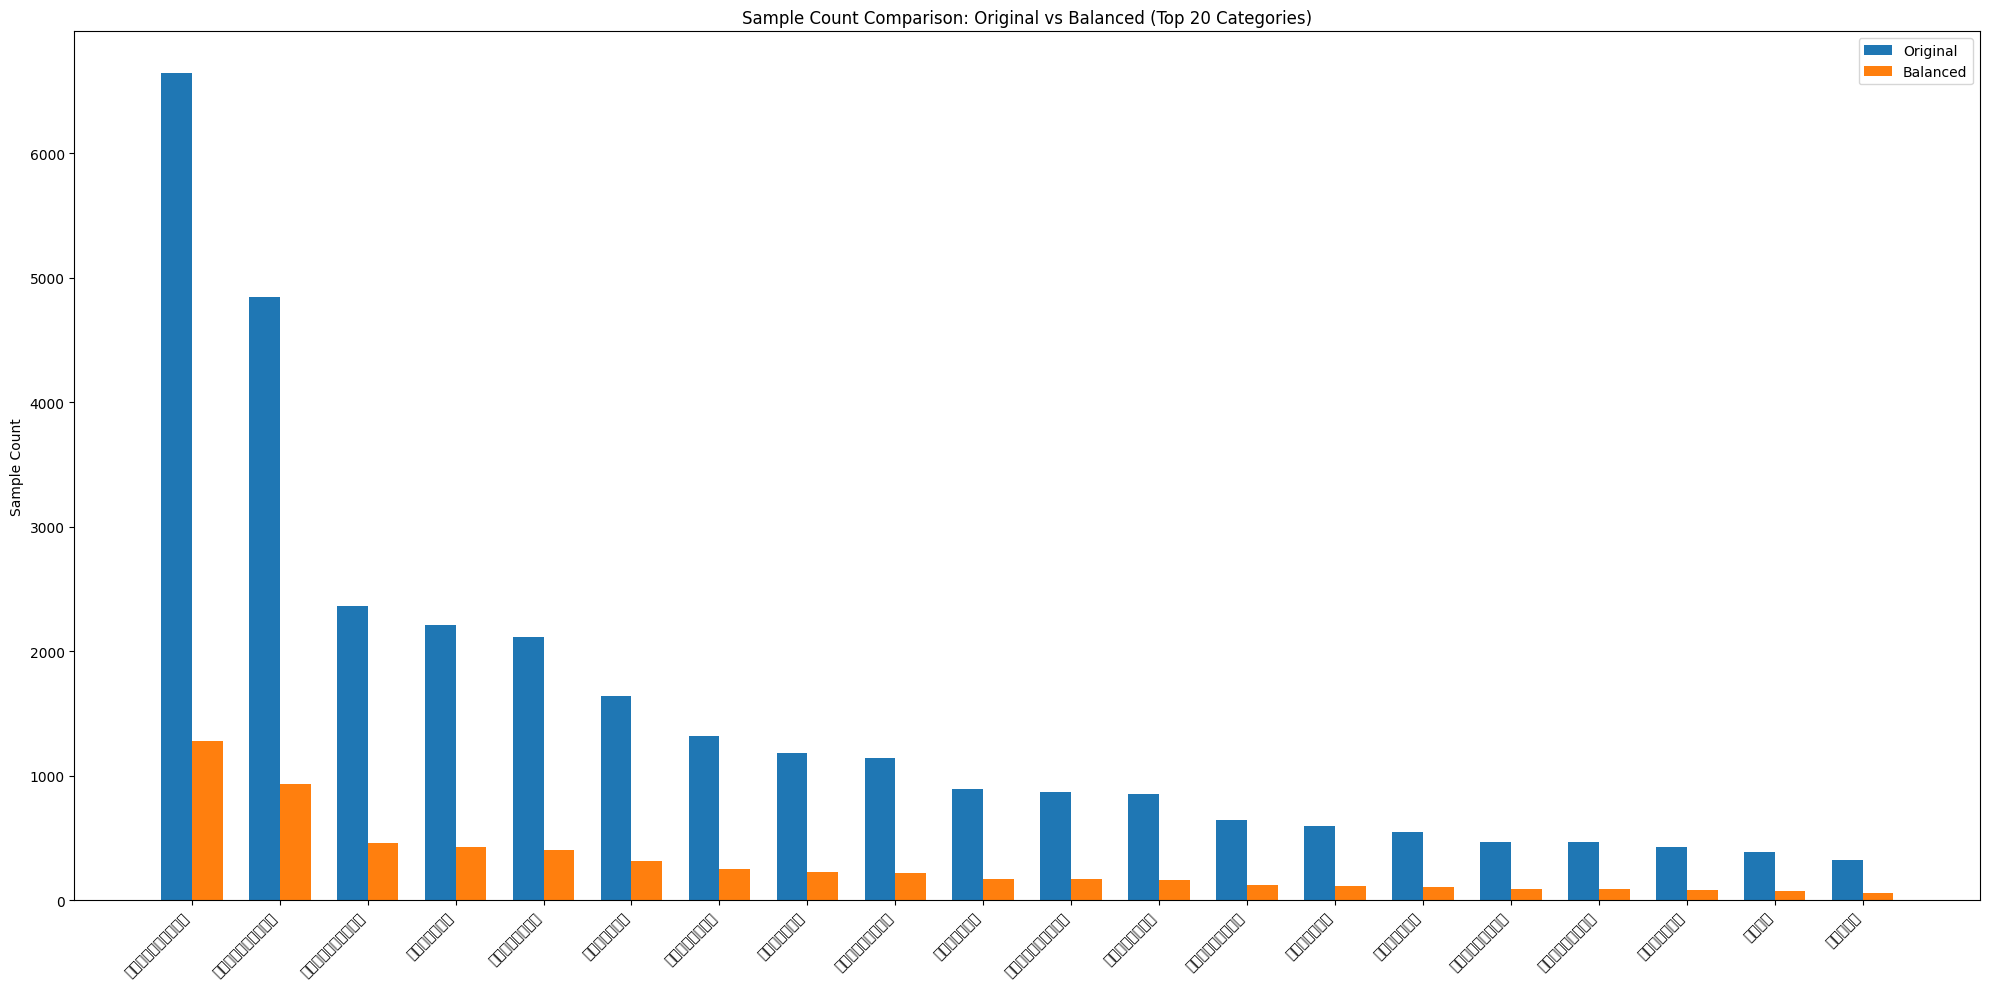

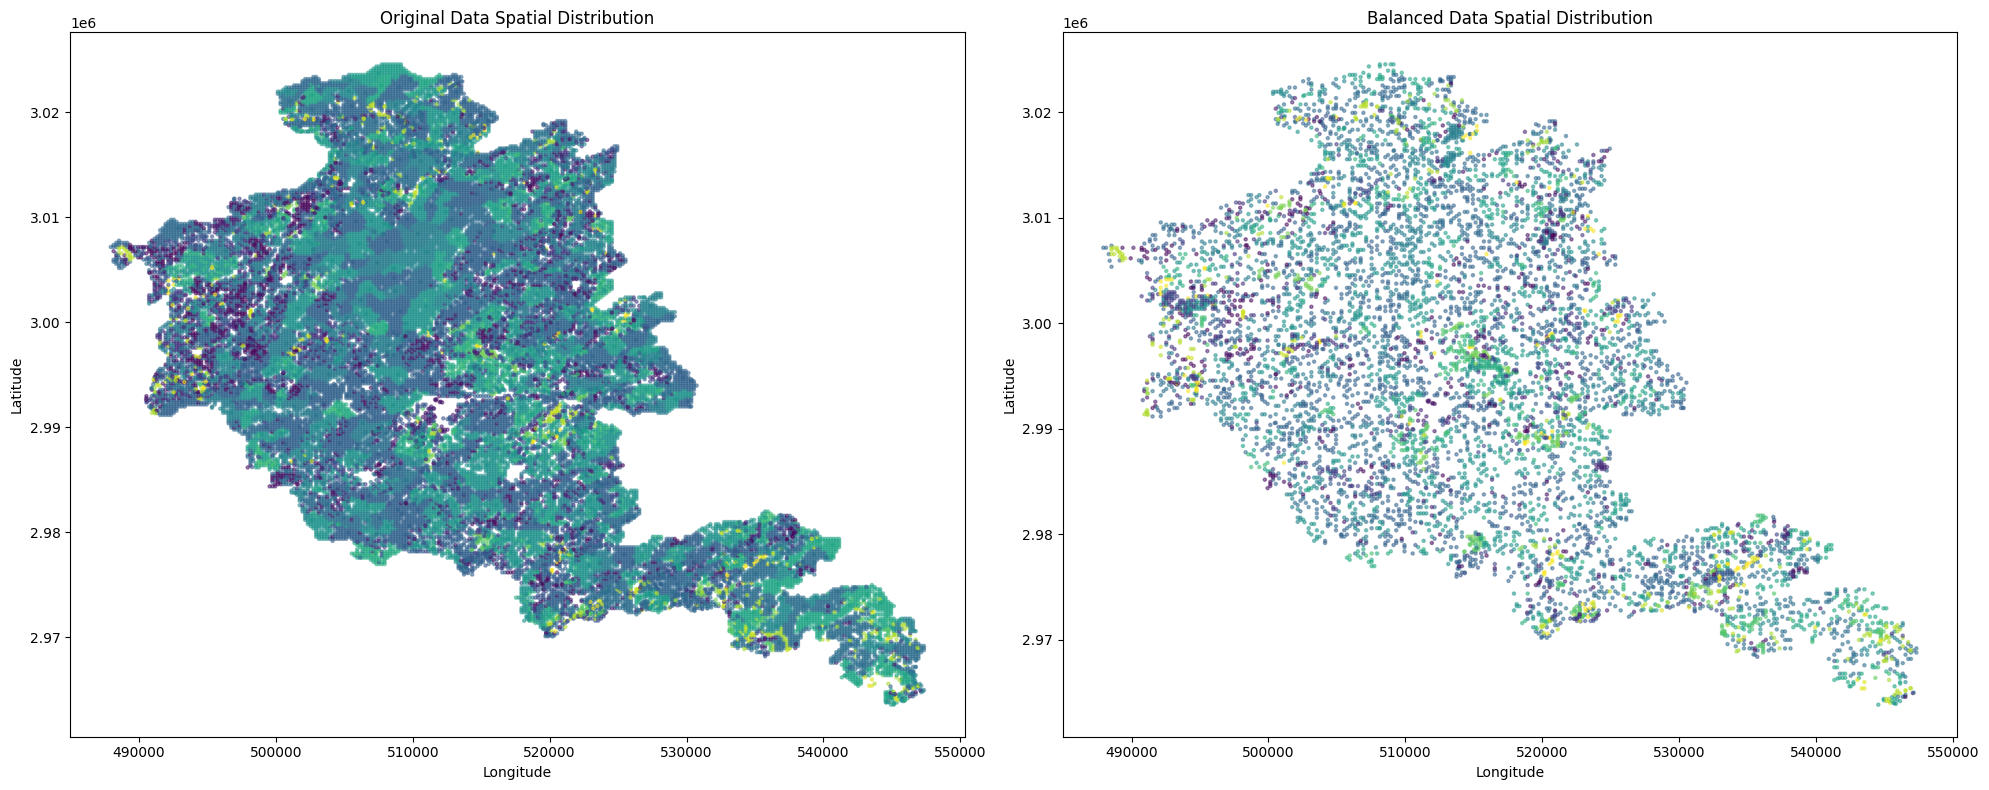

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial import cKDTree

def pca_density_downsample(df_category, target_samples, feature_columns, n_components=0.95):
    # Prepare the feature matrix
    X = df_category[['lon', 'lat'] + feature_columns].values
    
    # Standardize the features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    # Use k-d tree for efficient nearest neighbor search
    tree = cKDTree(X_pca)
    
    # Calculate the distance to the k-th nearest neighbor
    k = min(50, len(X_pca) - 1)  # Use 50 or the maximum possible if less than 50 samples
    distances, _ = tree.query(X_pca, k=k)
    density = 1 / distances[:, -1]  # Use the distance to the k-th neighbor as a proxy for density
    
    # Inverse density sampling
    p = 1.0 / density
    p /= p.sum()
    
    # Sample based on inverse density
    indices = np.random.choice(len(X), size=min(target_samples, len(X)), replace=False, p=p)
    
    return df_category.iloc[indices]

def adaptive_pca_balance(df, feature_columns, target_samples=500, low_threshold=100, high_threshold=1000):
    category_counts = df['NEW_TZ'].value_counts()
    
    resampled_dfs = []
    for category, count in category_counts.items():
        df_category = df[df['NEW_TZ'] == category]
        
        if count < low_threshold:
            # Keep original for low sample categories
            resampled_df = df_category
        elif count > high_threshold:
            # Use PCA-based density downsampling for high sample categories
            target = max(target_samples, int(count * target_samples / high_threshold))
            resampled_df = pca_density_downsample(df_category, target, feature_columns)
        else:
            # For categories between thresholds, adjust sample size proportionally
            target = int(count * target_samples / high_threshold)
            if count > target:
                resampled_df = pca_density_downsample(df_category, target, feature_columns)
            else:
                resampled_df = df_category

        resampled_dfs.append(resampled_df)
    
    final_df = pd.concat(resampled_dfs, ignore_index=True)
    return final_df

def visualize_samples(original_df, balanced_df, n_categories=20):
    # Select top n categories by sample count
    top_categories = original_df['NEW_TZ'].value_counts().nlargest(n_categories).index

    # Prepare data for visualization
    original_counts = original_df['NEW_TZ'].value_counts()
    balanced_counts = balanced_df['NEW_TZ'].value_counts()

    # Create bar plot
    fig, ax = plt.subplots(figsize=(20, 10))
    x = np.arange(len(top_categories))
    width = 0.35

    ax.bar(x - width/2, [original_counts.get(cat, 0) for cat in top_categories], width, label='Original')
    ax.bar(x + width/2, [balanced_counts.get(cat, 0) for cat in top_categories], width, label='Balanced')

    ax.set_ylabel('Sample Count')
    ax.set_title('Sample Count Comparison: Original vs Balanced (Top 20 Categories)')
    ax.set_xticks(x)
    ax.set_xticklabels(top_categories, rotation=45, ha='right')
    ax.legend()

    plt.tight_layout()
    plt.show()

    # Create scatter plot for spatial distribution
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    scatter1 = ax1.scatter(original_df['lon'], original_df['lat'], c=original_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax1.set_title('Original Data Spatial Distribution')
    ax1.set_xlabel('Longitude')
    ax1.set_ylabel('Latitude')

    scatter2 = ax2.scatter(balanced_df['lon'], balanced_df['lat'], c=balanced_df['NEW_TZ'].astype('category').cat.codes, s=5, alpha=0.5)
    ax2.set_title('Balanced Data Spatial Distribution')
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Latitude')

    plt.tight_layout()
    plt.show()

# Load your data
df = pd.read_csv(r"C:\Users\Runker\Desktop\test\csv\point_sample.csv")

# Define the feature columns to consider (excluding 'lon', 'lat', and 'NEW_TZ')
feature_columns = ['aligned_Aspect', 'aligned_Channel Network Base Level',
                   'aligned_Channel Network Distance', 'aligned_Closed Depressions',
                   'aligned_Convergence Index', 'aligned_dem', 
                   'aligned_ETP2022_mean', 'aligned_evi', 'aligned_LS-Factor',
                   'aligned_lswi', 'aligned_mndwi', 'aligned_ndmi', 'aligned_ndvi',
                   'aligned_ndwi', 'aligned_NIGHT2022', 'aligned_pca_1', 'aligned_pca_2',
                   'aligned_Plan Curvature', 'aligned_PRE2022_mean',
                   'aligned_Profile Curvature', 'aligned_Relative Slope Position',
                   'aligned_savi', 'aligned_Slope', 'aligned_TMP2022_mean',
                   'aligned_Topographic Wetness Index', 'aligned_Total Catchment Area',
                   'aligned_Valley Depth', 'aligned_vari', 'clipped_dem',
                   'MRRTF', 'MRVBF', 'slope_postion_101']

# Apply the adaptive PCA-based balanced sampling
balanced_df = adaptive_pca_balance(df, feature_columns, target_samples=385, low_threshold=85, high_threshold=1995)

# Display information about the balanced dataset
print("Original sample counts:")
print(df['NEW_TZ'].value_counts())
print("\nBalanced sample counts:")
print(balanced_df['NEW_TZ'].value_counts())
print(f"\nTotal samples before balancing: {len(df)}")
print(f"Total samples after balancing: {len(balanced_df)}")

# Visualize the results
visualize_samples(df, balanced_df)

# Save the balanced dataset to a new CSV file
balanced_df.to_csv(r"C:\Users\Runker\Desktop\test\csv\pca_balanced_sample_data.csv", index=False)

In [32]:
balanced_df['NEW_TZ'].value_counts().to_dict()

{'腐中层壤质黄色石灰土': 1282,
 '腐薄层壤质黄色石灰土': 935,
 '腐厚层壤质黄色石灰土': 456,
 '腐中层硅质黄壤': 426,
 '腐中层灰泥质黄壤': 407,
 '腐中层泥质黄壤': 316,
 '腐厚层灰泥质黄壤': 254,
 '腐薄层硅质黄壤': 228,
 '中层壤质黄色石灰土': 220,
 '腐薄层泥质黄壤': 171,
 '腐中层黏质黄色石灰土': 168,
 '腐薄层灰泥质黄壤': 163,
 '薄层壤质黄色石灰土': 124,
 '腐厚层泥质黄壤': 114,
 '腐厚层硅质黄壤': 106,
 '中层黏质黄色石灰土': 90,
 '厚层壤质黄色石灰土': 89,
 '中层灰泥质黄壤': 82,
 '石灰泥田': 75,
 '黄黄泥田': 75,
 '黄浅鳝泥田': 71,
 '薄层硅质黄壤': 71,
 '厚层黏质黄色石灰土': 65,
 '浅石灰泥田': 61,
 '腐厚层红泥质黄壤': 58,
 '腐中层暗泥质黄壤': 56,
 '腐厚层暗泥质黄壤': 56,
 '浅鳝泥田': 55,
 '青潮泥田': 53,
 '青灰泥田': 53,
 '紫泥田': 52,
 '腐中层壤质中性紫色土': 52,
 '薄层壤质中性紫色土': 51,
 '厚层红泥质黄壤': 50,
 '厚层泥质黄壤': 49,
 '腐薄层黏质黄色石灰土': 47,
 '潮泥田': 46,
 '薄层红泥质黄壤': 46,
 '厚层灰泥质黄壤': 45,
 '中层硅质黄壤': 44,
 '腐薄层暗泥质黄壤': 40,
 '酸浅紫泥田': 37,
 '黄浅砂泥田': 37,
 '腐厚层黏质黄色石灰土': 36,
 '轻漂潮泥田': 35,
 '黄浅灰泥田': 34,
 '腐薄层壤质中性紫色土': 34,
 '中层泥质黄壤': 34,
 '轻漂白粉泥田': 32,
 '中层砂泥质黄壤': 32,
 '薄层泥质黄壤': 31,
 '厚层硅质黄壤': 31,
 '黄浅白粉泥田': 31,
 '薄层灰泥质黄壤': 30,
 '腐厚层泥质黄棕壤': 29,
 '腐厚层砂泥质黄壤': 27,
 '腐中层砂泥质黄壤': 26,
 '薄层黏质黄色石灰土': 26,
 '潮砂泥田': 25,
 '浅黄泥田': 24,
 '腐中层红泥质黄壤': 22,
 '黄浅红泥田'

In [33]:
len(balanced_df['NEW_TZ'].value_counts().to_dict())

114

In [34]:
df['NEW_TZ'].value_counts().to_dict()

{'腐中层壤质黄色石灰土': 6648,
 '腐薄层壤质黄色石灰土': 4845,
 '腐厚层壤质黄色石灰土': 2364,
 '腐中层硅质黄壤': 2210,
 '腐中层灰泥质黄壤': 2111,
 '腐中层泥质黄壤': 1642,
 '腐厚层灰泥质黄壤': 1321,
 '腐薄层硅质黄壤': 1186,
 '中层壤质黄色石灰土': 1144,
 '腐薄层泥质黄壤': 890,
 '腐中层黏质黄色石灰土': 871,
 '腐薄层灰泥质黄壤': 849,
 '薄层壤质黄色石灰土': 646,
 '腐厚层泥质黄壤': 595,
 '腐厚层硅质黄壤': 551,
 '中层黏质黄色石灰土': 467,
 '厚层壤质黄色石灰土': 464,
 '中层灰泥质黄壤': 429,
 '石灰泥田': 389,
 '浅石灰泥田': 321,
 '腐中层暗泥质黄壤': 295,
 '腐薄层黏质黄色石灰土': 246,
 '潮泥田': 241,
 '厚层灰泥质黄壤': 236,
 '中层硅质黄壤': 230,
 '腐薄层暗泥质黄壤': 209,
 '腐厚层黏质黄色石灰土': 191,
 '中层泥质黄壤': 179,
 '黄浅白粉泥田': 165,
 '薄层泥质黄壤': 162,
 '薄层灰泥质黄壤': 156,
 '腐厚层泥质黄棕壤': 154,
 '腐中层砂泥质黄壤': 135,
 '潮砂泥田': 132,
 '腐中层红泥质黄壤': 117,
 '黄白粉泥田': 110,
 '腐薄层泥质黄棕壤': 107,
 '中层红泥质黄壤': 97,
 '腐薄层红泥质黄壤': 95,
 '腐中层泥质黄棕壤': 92,
 '黄黄泥田': 75,
 '薄层硅质黄壤': 71,
 '黄浅鳝泥田': 71,
 '厚层黏质黄色石灰土': 65,
 '腐厚层红泥质黄壤': 58,
 '腐厚层暗泥质黄壤': 56,
 '浅鳝泥田': 55,
 '青灰泥田': 53,
 '青潮泥田': 53,
 '腐中层壤质中性紫色土': 52,
 '紫泥田': 52,
 '薄层壤质中性紫色土': 51,
 '厚层红泥质黄壤': 50,
 '厚层泥质黄壤': 49,
 '薄层红泥质黄壤': 46,
 '酸浅紫泥田': 37,
 '黄浅砂泥田': 37,
 '轻漂潮泥田': 35,
 '腐薄层壤质中性紫色土': 34,
 '黄浅灰

In [35]:
len(df['NEW_TZ'].value_counts().to_dict())

114